We import needed libraries

In [1]:
from typing import Union

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

We define necessary functions

In [2]:
def unique_with_same_order(a: np.ndarray, axis=None):
    return a[np.sort(np.unique(a, return_index=True, axis=axis)[1])]

def convert_to_one_hot(a: Union[np.ndarray, list], classes: np.ndarray = None):
    if isinstance(a, list):
        a = np.array(a)
    if classes is None:
        classes = unique_with_same_order(a, axis=0)
    return np.vstack([a == v for v in classes]).T.astype(np.float64)

def standard_scaling(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

def train_test_split(X = None, population_size: int = None, split: float = 0.2, random_state: int = 42):
    """
    params:
    X: np.ndarray or pd.DataFrame passed to infer population_size
    population_size: can be passed instead of X
    split: fraction of dataset that goes into test set
    """
    if X is not None:
        population_size = X.shape[0]
        
    np.random.seed(random_state)        
    shuffled_index = np.random.permutation(np.arange(population_size))
    
    test_size = int(population_size * split)
    test_index = shuffled_index[:test_size]
    train_index = shuffled_index[test_size:]
    return train_index, test_index

def softmax(a, rowwise=True):
    if rowwise:
        return (np.exp(a).T / np.exp(a).T.sum(0)).T
    else:
        return np.exp(a) / np.exp(a).sum()
    
def predict_proba(params, X):
    return softmax(params.dot(X.T).T)
    
def predict(params, X):
    return np.argmax(
        predict_proba(params, X), 
        axis=1)

def cross_entropy(y, y_hat, X = None, gradient: bool = False):
    """
    params
    y: ground_truth labels encoded as 1-hot
    y_hat: same shape as y, but with probabilities of classes instead of ground_truth
    X: required only if gradient set to True 
    gradient: True if function should return a gradient of cross_entropy
    """
    if gradient:
        if X is None:
            raise ValueError("X parameter cannot be None when calculating gradient")
        return ((y_hat - y).T @ X) / y_hat.shape[0]
    else:
        return -(1/y.shape[0]) * np.multiply(y, np.log(y_hat)).sum()
    
def accuracy(output, target):
    return np.sum(output == target) / target.shape[0]

We define model implementation

In [3]:
class LearningSchedule:
    def __init__(self, function):
        """
        params
        function: a function that returns learning rate for any x between 0 and 1
        """
        self.schedule_function: callable = function
    
    def __call__(self, epoch_i: int, n_epochs: int):
        return self.schedule_function(epoch_i / (n_epochs - 1))
        
class UpDownCurve:
    def __init__(self, lower: float = 0.02, upper: float = 0.04, argmax: float = 0.2):
        """
        params
        lower: start value of learning rate
        upper: peak value of learning rate
        argmax: argument for which peak learning rate should be reached
        """
        self.lower = lower
        self.upper = upper
        self.argmax = argmax
    
    def __call__(self, s: Union[float, np.ndarray]):
        """
        Get learning rate for passed parameter
        params
        s: value(s) between 0 and 1 signifying current progress of training
        """
        vrange = self.upper - self.lower
        part1 = ((-np.cos(s * np.pi / self.argmax) + 1) / 2 * vrange + self.lower) * (s <= self.argmax)
        part2 = ((- np.cos((s - 1) * np.pi / (1-self.argmax)) + 1) / 2 * self.upper) * (s > self.argmax)
        return part1 + part2
    
    def plot(self):
        """
        Plot the curve to have a better understanding of the curve
        """
        space = np.arange(0,1,0.01)
        plt.plot(space, self(space))

class TrainingLog:
    def __init__(self):
        self.validation_loss = list()
        self.training_loss = list()
    
    def plot(self):
        plt.xlabel("epoch")
        plt.ylabel("loss value")
        plt.plot(sr_cls.training_log.training_loss)
        plt.plot(sr_cls.training_log.validation_loss)
        plt.legend(("train", "validation"))
        plt.show()

class SoftmaxRegressionClassifier:
    def __init__(self):
        self.params: np.ndarray = None
        self.classes: np.ndarray = None
        self.training_log: TrainingLog = None
        
    def fit(self, X, y, X_val, y_val, 
            learning_rate: float = 0.01,
            learning_schedule: LearningSchedule = None,
            n_epochs: int = 10):
        
        if learning_schedule is None:
            learning_schedule = LearningSchedule(lambda a: learning_rate)
            
        self.training_log = TrainingLog()
        n_params = X.shape[1]
        self.classes = unique_with_same_order(y, axis=0)
        self._init_params(self.classes.shape[0], n_params)
        y_oh = convert_to_one_hot(y, classes=self.classes)
        
        for epoch_i in range(n_epochs):
            learning_rate = learning_schedule(epoch_i, n_epochs)
            y_hat = self.predict_proba(X)
            loss = cross_entropy(y_oh, y_hat)
            gradient = cross_entropy(y_oh, y_hat, X, gradient=True)
            self.params -= learning_rate * gradient
            val_loss = cross_entropy(convert_to_one_hot(y_val, 
                                                        classes=self.classes), 
                                     self.predict_proba(X_val))
            self.training_log.validation_loss.append(val_loss)
            self.training_log.training_loss.append(loss)
            
    def _init_params(self, n_classes, n_params):
        self.params = np.random.normal(size=(n_classes, n_params))
    
    def predict_proba(self, X):
        if self.params is None:
            raise AssertionError("You cannot predict before you fit the model")
        return softmax(self.params.dot(X.T).T)
    
    def predict(self, X):
        return self.classes[np.argmax(
            self.predict_proba(X), 
            axis=1)]

We download the dataset

In [4]:
iris = datasets.load_iris()

We preprocess the data

In [5]:
X = iris.data
y = iris.target_names[iris.target]

population_size = X.shape[0]
X_scaled = standard_scaling(X)

We split the data

In [20]:
val_split = 0.2 
train_index, val_index = train_test_split(X_scaled, split=0.2, random_state=5)
X_train, y_train = X_scaled[train_index], y[train_index]
X_val, y_val = X_scaled[val_index], y[val_index]

We train the model and show stats about training effects

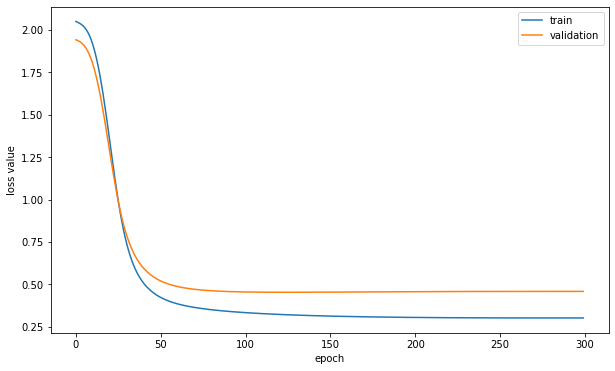

val_loss: 0.458
train_loss: 0.302
val_accuracy: 0.8
train_accuracy: 0.858
bias error: 0.142
variance error: 0.058


In [21]:
sr_cls = SoftmaxRegressionClassifier()
sr_cls.fit(X_train, y_train, X_val, y_val,
           learning_schedule=LearningSchedule(
               UpDownCurve(lower=0.002, upper=0.2, argmax=0.2)),
           n_epochs=300)

plt.figure(figsize=(10,6))
sr_cls.training_log.plot()

print('val_loss:', sr_cls.training_log.validation_loss[-1].round(3))
print('train_loss:', sr_cls.training_log.training_loss[-1].round(3))

val_accuracy = accuracy(sr_cls.predict(X_val), y_val)
train_accuracy = accuracy(sr_cls.predict(X_train), y_train)
print('val_accuracy:', val_accuracy.round(3))
print('train_accuracy:', train_accuracy.round(3))
bias = 1 - train_accuracy
variance = 1 - val_accuracy - bias
print('bias error:', bias.round(3))
print('variance error:', variance.round(3))